In [0]:
#mount google drive to access data
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'impact/'

In [0]:
#unzip data into the main folder
!unzip -qq ./gdrive/My\ Drive/impact/tiny-imagenet-200.zip

In [0]:
#run the model script the initialize it
%run ./gdrive/My\ Drive/impact/resnet.ipynb

In [4]:
#check the code is working
Resnet(BasicBlock,[3,3,3])

Resnet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (stage1): Sequential(
    (0): BasicBlock(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (drop): Dropout(p=0.3, inplace)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace)
    )
    (1): BasicBlock(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (drop): Dropout(p=0.3, inplace)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math

plt.ion()

In [0]:
#CALCULATE THE MEAN AND STANDARD DEVIATION OF THE tiny-imagenet dataset

#data_dir = 'tiny-imagenet-200'
#train_transform = torchvision.transforms.Compose([transforms.ToTensor()])
#train_set = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'),train_transform)
#train_set.transform
'''
dataloader = torch.utils.data.DataLoader(train_set, batch_size=5000, shuffle=False, num_workers=4)

pop_mean = []
pop_std = []
for data in dataloader:
    # shape (batch_size, 3, height, width)
    numpy_image = data[0].numpy()
    
    # shape (3,)
    batch_mean = np.mean(numpy_image, axis=(0,2,3))
    batch_std = np.std(numpy_image, axis=(0,2,3))
    
    pop_mean.append(batch_mean)
    pop_std.append(batch_std)

pop_mean = np.array(pop_mean).mean(axis=0)
pop_std = np.array(pop_std).mean(axis=0)

pop_mean: [0.48024565, 0.44807228, 0.39754787]
pop_std: [0.27613413, 0.26838112, 0.2801042 ]
'''
pass

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.48, 0.448, 0.398], [0.276, 0.268, 0.280])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.48, 0.448, 0.398], [0.276, 0.268, 0.280])
    ]),
}

#read the data
data_dir = 'tiny-imagenet-200'
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1000,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

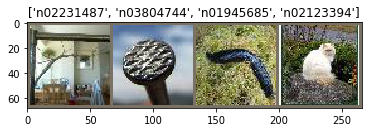

In [7]:
#script taken from pytorch.org
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.48, 0.448, 0.398])
    std = np.array( [0.276, 0.268, 0.280])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

In [0]:
#script taken from pytorch.org
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
#script taken from pytorch.org
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
#an lr finder module based on leslie smith's one cycle policy
%run ./gdrive/My\ Drive/impact/lr_finder.py

<Figure size 432x288 with 0 Axes>

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


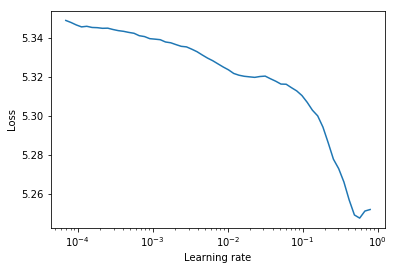

In [0]:
#find the best learning rate
model = Resnet(BasicBlock,[9,9,9])
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-4)
optimizer = optim.SGD(model.parameters(), lr=1e-5, weight_decay=1e-3,momentum=0.95)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=100, num_iter=100)
lr_finder.plot()

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


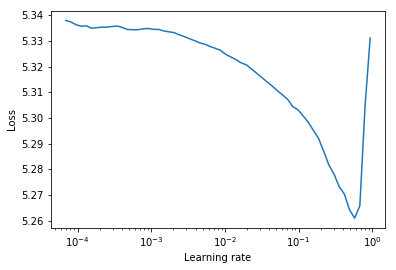

In [0]:
model = Resnet(BasicBlock[9,9,9])
optimizer = optim.SGD(model.parameters(), lr=1e-5, weight_decay=1e-3,momentum=0.85)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=100, num_iter=100)
lr_finder.plot()

In [0]:
#train a Resnet56
model= Resnet(BasicBlock,[9,9,9])
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.02, weight_decay=1e-3,momentum=0.95)
exp_lr_scheduler = lr_scheduler.CyclicLR(optimizer,base_lr=0.02,max_lr=0.1)
model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=90)

Epoch 0/89
----------
train Loss: 5.0625 Acc: 0.0267
val Loss: 6.2360 Acc: 0.0006

Epoch 1/89
----------
train Loss: 4.5341 Acc: 0.0682
val Loss: 6.3536 Acc: 0.0144

Epoch 2/89
----------
train Loss: 4.2032 Acc: 0.1032
val Loss: 7.6234 Acc: 0.0163

Epoch 3/89
----------
train Loss: 3.9639 Acc: 0.1364
val Loss: 7.7081 Acc: 0.0099

Epoch 4/89
----------
train Loss: 3.7681 Acc: 0.1635
val Loss: 9.7000 Acc: 0.0023

Epoch 5/89
----------
train Loss: 3.6080 Acc: 0.1873
val Loss: 9.0095 Acc: 0.0028

Epoch 6/89
----------
train Loss: 3.4628 Acc: 0.2107
val Loss: 9.1648 Acc: 0.0060

Epoch 7/89
----------
train Loss: 3.3472 Acc: 0.2296
val Loss: 9.2487 Acc: 0.0038

Epoch 8/89
----------
train Loss: 3.2490 Acc: 0.2457
val Loss: 9.8189 Acc: 0.0104

Epoch 9/89
----------
train Loss: 3.1553 Acc: 0.2638
val Loss: 8.0162 Acc: 0.0099

Epoch 10/89
----------
train Loss: 3.0864 Acc: 0.2751
val Loss: 10.1388 Acc: 0.0045

Epoch 11/89
----------
train Loss: 3.0101 Acc: 0.2876
val Loss: 8.8053 Acc: 0.0056

E

In [0]:
#train a Resnet20
model= Resnet(BasicBlock,[3,3,3])
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.02, weight_decay=1e-3,momentum=0.95)
exp_lr_scheduler = lr_scheduler.CyclicLR(optimizer,base_lr=0.02,max_lr=0.1)
model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=90)

Epoch 0/89
----------
train Loss: 5.1936 Acc: 0.0161
val Loss: 5.4017 Acc: 0.0001

Epoch 1/89
----------
train Loss: 4.8703 Acc: 0.0400
val Loss: 6.0406 Acc: 0.0010

Epoch 2/89
----------
train Loss: 4.5493 Acc: 0.0659
val Loss: 7.4362 Acc: 0.0008

Epoch 3/89
----------
train Loss: 4.3012 Acc: 0.0904
val Loss: 7.3631 Acc: 0.0064

Epoch 4/89
----------
train Loss: 4.1144 Acc: 0.1109
val Loss: 7.8645 Acc: 0.0031

Epoch 5/89
----------
train Loss: 3.9832 Acc: 0.1273
val Loss: 8.2755 Acc: 0.0022

Epoch 6/89
----------
train Loss: 3.8620 Acc: 0.1454
val Loss: 9.0314 Acc: 0.0025

Epoch 7/89
----------
train Loss: 3.7530 Acc: 0.1608
val Loss: 8.6151 Acc: 0.0042

Epoch 8/89
----------
train Loss: 3.6570 Acc: 0.1774
val Loss: 8.2993 Acc: 0.0019

Epoch 9/89
----------
train Loss: 3.5760 Acc: 0.1897
val Loss: 8.1933 Acc: 0.0080

Epoch 10/89
----------
train Loss: 3.5067 Acc: 0.2013
val Loss: 7.7582 Acc: 0.0103

Epoch 11/89
----------
train Loss: 3.4422 Acc: 0.2109
val Loss: 8.5545 Acc: 0.0081

Ep

In [0]:
#train a Resnet32
model= Resnet(BasicBlock,[5,5,5])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.02, weight_decay=1e-3,momentum=0.95)
exp_lr_scheduler = lr_scheduler.CyclicLR(optimizer,base_lr=0.02,max_lr=0.1)
model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=90)

Epoch 0/89
----------
train Loss: 5.1318 Acc: 0.0210
val Loss: 5.8548 Acc: 0.0002

Epoch 1/89
----------
train Loss: 4.6862 Acc: 0.0502
val Loss: 7.5392 Acc: 0.0035

Epoch 2/89
----------
train Loss: 4.3749 Acc: 0.0802
val Loss: 7.4067 Acc: 0.0090

Epoch 3/89
----------
train Loss: 4.1362 Acc: 0.1099
val Loss: 7.0964 Acc: 0.0249

Epoch 4/89
----------
train Loss: 3.9564 Acc: 0.1348
val Loss: 9.5935 Acc: 0.0008

Epoch 5/89
----------
train Loss: 3.8082 Acc: 0.1562
val Loss: 8.1803 Acc: 0.0026

Epoch 6/89
----------
train Loss: 3.6720 Acc: 0.1755
val Loss: 8.6988 Acc: 0.0062

Epoch 7/89
----------
train Loss: 3.5663 Acc: 0.1926
val Loss: 8.3397 Acc: 0.0058

Epoch 8/89
----------
train Loss: 3.4811 Acc: 0.2066
val Loss: 9.1548 Acc: 0.0023

Epoch 9/89
----------
train Loss: 3.3887 Acc: 0.2239
val Loss: 8.6879 Acc: 0.0056

Epoch 10/89
----------
train Loss: 3.3197 Acc: 0.2322
val Loss: 9.3124 Acc: 0.0023

Epoch 11/89
----------
train Loss: 3.2478 Acc: 0.2458
val Loss: 8.9864 Acc: 0.0034

Ep